In [23]:
from binance.client import Client
import pandas as pd
import time

# 1. Binance API 클라이언트 생성 (API 키와 시크릿을 입력)
api_key = 'BINANCE_API_KEY'
api_secret = 'BINANCE_API_SECRET_KEY'
client = Client(api_key, api_secret)

# 2. 1시간 봉 데이터를 수집하는 함수 정의
def get_binance_klines(symbol, interval, start_str, end_str=None):
    # Binance API로 1시간 봉 데이터 가져오기
    return client.get_historical_klines(symbol, interval, start_str, end_str, limit=1000)

# 3. 데이터를 구간별로 수집하는 함수
def fetch_data(symbol, interval, start_str, end_str):
    data = []
    counter = 0  # 수집 횟수를 세기 위한 카운터
    while True:
        # 데이터 수집
        klines = get_binance_klines(symbol, interval, start_str, end_str)
        if not klines:
            break
        data.extend(klines)

        # 마지막 데이터의 끝 시간으로 다음 요청의 시작 시간 설정
        last_time = klines[-1][0]
        start_str = pd.to_datetime(last_time, unit='ms') + pd.Timedelta(hours=1)
        start_str = str(start_str)

        # 수집 횟수 카운트 및 출력
        counter += 1
        print(f"{counter}회 완료. 1000개의 데이터 수집 완료.")

        # 요청을 너무 많이 하지 않도록 대기 (1초 대기)
        time.sleep(1)

    return data

# 4. 비트코인 1시간 봉 데이터 수집
symbol = 'BTCUSDT'
interval = Client.KLINE_INTERVAL_1HOUR
start_date = "2017-08-15"
end_date = "2024-09-07"

# 데이터를 구간별로 수집
btc_data = fetch_data(symbol, interval, start_date, end_date)

# 5. 데이터를 DataFrame으로 변환
btc_df = pd.DataFrame(btc_data, columns=[
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 
    'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 
    'Taker buy quote asset volume', 'Ignore'])

# 타임스탬프를 날짜로 변환
btc_df['Open time'] = pd.to_datetime(btc_df['Open time'], unit='ms')

# 필요한 컬럼만 추출
btc_df = btc_df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]

# 6. DataFrame을 CSV 파일로 저장
btc_df.to_csv('btc_1h_data_2017_to_2024.csv', index=False)

# 결과 확인
print(f"데이터 수집 완료. 총 {len(btc_df)}개의 1시간 봉 데이터가 수집되었습니다.")


1회 완료. 1000개의 데이터 수집 완료.
데이터 수집 완료. 총 61741개의 1시간 봉 데이터가 수집되었습니다.


In [24]:
import pandas as pd

# 1. CSV 파일에서 데이터를 로드 (파일 경로 수정 필요)
btc_df = pd.read_csv('btc_1h_data_2017_to_2024.csv')

# 2. 타임스탬프를 pandas의 datetime 형식으로 변환
btc_df['Open time'] = pd.to_datetime(btc_df['Open time'])

# 3. 첫 번째 행의 시간 확인 (2017-08-17 04:00:00) ~ UTC 08:00:00 이전의 데이터를 제거
btc_df = btc_df[btc_df['Open time'] >= pd.Timestamp('2017-08-17 08:00:00')]

# 4. 마지막 행의 시간 확인 (2024-09-06 00:00:00) ~ UTC 08:00:00 이후의 데이터를 제거
btc_df = btc_df[btc_df['Open time'] < pd.Timestamp('2024-09-06 08:00:00')]

# 5. 인덱스를 타임스탬프로 설정 (UTC 기준)
btc_df.set_index('Open time', inplace=True)

# 6. UTC 08:00부터 익일 08:00까지의 데이터를 1일로 그룹화
btc_daily_resampled = btc_df.resample('24H', offset=pd.Timedelta(hours=8)).agg({
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
})

# 7. 깔끔한 데이터 저장
btc_daily_resampled.to_csv('btc_deribit_daily_cleaned.csv')

# 결과 확인
print(btc_daily_resampled.head())


                        Open     High      Low    Close       Volume
Open time                                                           
2017-08-17 08:00:00  4333.32  4485.39  4134.61  4300.25  1237.643584
2017-08-18 08:00:00  4285.00  4371.52  3933.21  4033.47   896.568719
2017-08-19 08:00:00  4033.47  4156.56  3850.00  4155.87   195.262429
2017-08-20 08:00:00  4155.87  4211.08  3953.40  4043.63   875.281101
2017-08-21 08:00:00  4043.63  4088.12  3400.00  3798.08   530.236653


In [25]:
import pandas as pd

# 1. CSV 파일에서 데이터를 로드 (파일 경로 수정 필요)
btc_daily_resampled = pd.read_csv('btc_deribit_daily_cleaned.csv')

# 2. 타임스탬프를 pandas의 datetime 형식으로 변환
btc_daily_resampled['Open time'] = pd.to_datetime(btc_daily_resampled['Open time'])

# 3. 시가-종가 간의 변화량(%) 계산
btc_daily_resampled['Open-Close Change %'] = ((btc_daily_resampled['Close'] - btc_daily_resampled['Open']) / btc_daily_resampled['Open']) * 100

# 4. 고가-저가 간의 변화량(%) 계산
btc_daily_resampled['High-Low Change %'] = ((btc_daily_resampled['High'] - btc_daily_resampled['Low']) / btc_daily_resampled['Low']) * 100

# 5. 필요한 컬럼(날짜, 시가-종가 변화량, 고가-저가 변화량)만 선택
final_df = btc_daily_resampled[['Open time', 'Open-Close Change %', 'High-Low Change %']]

# 6. 최종 결과를 CSV 파일로 저장
final_df.to_csv('btc_daily_change_rates.csv', index=False)

# 결과 확인
print(final_df.head())


            Open time  Open-Close Change %  High-Low Change %
0 2017-08-17 08:00:00            -0.763156           8.483992
1 2017-08-18 08:00:00            -5.870012          11.143824
2 2017-08-19 08:00:00             3.034608           7.962597
3 2017-08-20 08:00:00            -2.700758           6.517934
4 2017-08-21 08:00:00            -6.072514          20.238824


/var/folders/fg/h9_6v20d7dbbhrb1l0rll2qm0000gn/T/ipykernel_91635/1483247371.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  positive_changes['year'] = positive_changes['Open time'].dt.year
/var/folders/fg/h9_6v20d7dbbhrb1l0rll2qm0000gn/T/ipykernel_91635/1483247371.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  negative_changes['year'] = negative_changes['Open time'].dt.year


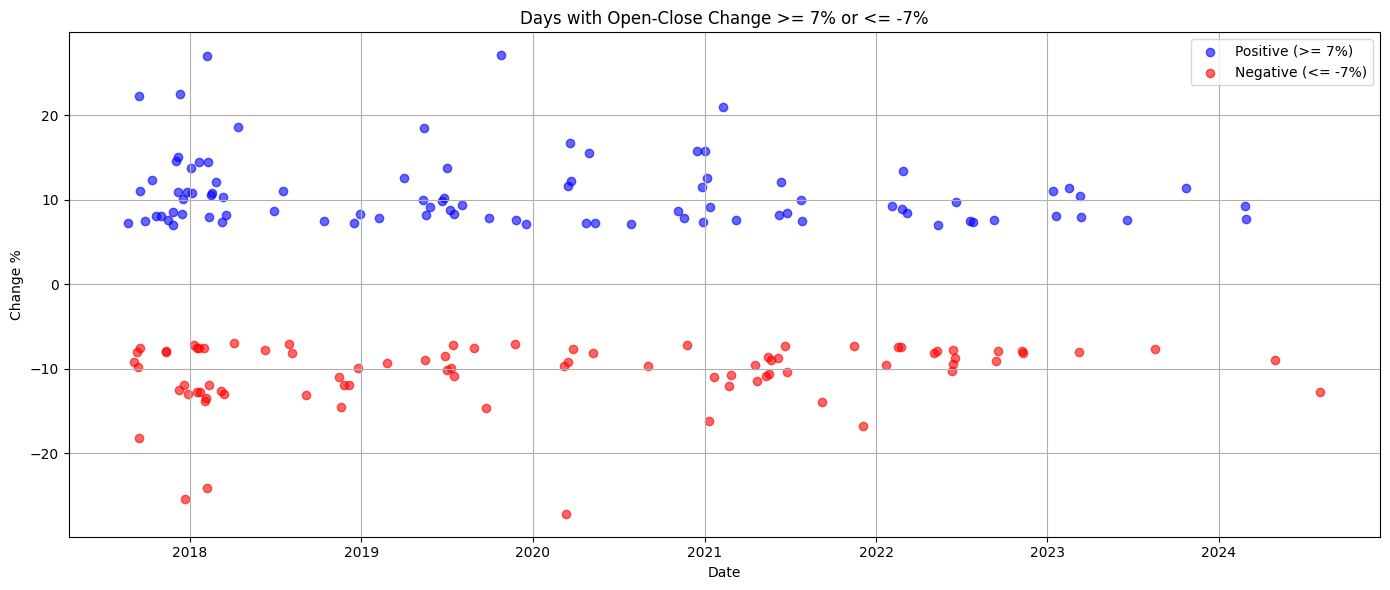

--------------------------------
Total number of days: 2577
Positive days (>= 7%): 91 days, 3.53% of total
Negative days (<= -7%): 83 days, 3.22% of total


(year
 2017    17
 2018    18
 2019    16
 2020    12
 2021    10
 2022     9
 2023     7
 2024     2
 dtype: int64,
 year
 2017    11
 2018    22
 2019    10
 2020     7
 2021    16
 2022    13
 2023     2
 2024     2
 dtype: int64)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. CSV 파일 불러오기
btc_daily_resampled = pd.read_csv('btc_daily_change_rates.csv')

# 2. 타임스탬프를 pandas의 datetime 형식으로 변환
btc_daily_resampled['Open time'] = pd.to_datetime(btc_daily_resampled['Open time'])

# 3. 변수 k 설정 (변화율 기준)
k = 7

# 4. 변화율이 k% 이상인 날들을 필터링 (플러스와 마이너스 모두 포함)
positive_changes = btc_daily_resampled[btc_daily_resampled['Open-Close Change %'] >= k]
negative_changes = btc_daily_resampled[btc_daily_resampled['Open-Close Change %'] <= -k]

# 5. 년도별로 몇 번의 변화가 있었는지 계산
positive_changes['year'] = positive_changes['Open time'].dt.year
negative_changes['year'] = negative_changes['Open time'].dt.year

positive_yearly_count = positive_changes.groupby('year').size()
negative_yearly_count = negative_changes.groupby('year').size()

# 6. 시각화
plt.figure(figsize=(14, 6))

# Positive Changes (5% 이상 상승)
plt.scatter(positive_changes['Open time'], positive_changes['Open-Close Change %'], color='blue', label=f'Positive (>= {k}%)', alpha=0.6)

# Negative Changes (-5% 이하 하락)
plt.scatter(negative_changes['Open time'], negative_changes['Open-Close Change %'], color='red', label=f'Negative (<= -{k}%)', alpha=0.6)

# 그래프 타이틀 및 축 라벨 설정
plt.title(f"Days with Open-Close Change >= {k}% or <= -{k}%")
plt.xlabel('Date')
plt.ylabel('Change %')

plt.grid(True)


# 범례 추가
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


print("--------------------------------")
# 전체 일수 대비 긍정적, 부정적 변화의 비율 계산 및 출력
total_days = len(btc_daily_resampled)

positive_count = len(positive_changes)
negative_count = len(negative_changes)

positive_prob = (positive_count / total_days) * 100
negative_prob = (negative_count / total_days) * 100

# 결과 출력
print(f"Total number of days: {total_days}")
print(f"Positive days (>= {k}%): {positive_count} days, {positive_prob:.2f}% of total")
print(f"Negative days (<= -{k}%): {negative_count} days, {negative_prob:.2f}% of total")
# 7. 연도별 변화 수 출력
positive_yearly_count, negative_yearly_count